In [280]:
import h5py
import os

directory = "./data/"
data_folder = directory + "8-5-24/h5oina/"
output_folder =  './'

h5_files = os.listdir(data_folder)
sorted_files = sorted(h5_files, key=lambda x: int(x.split(' ')[4]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


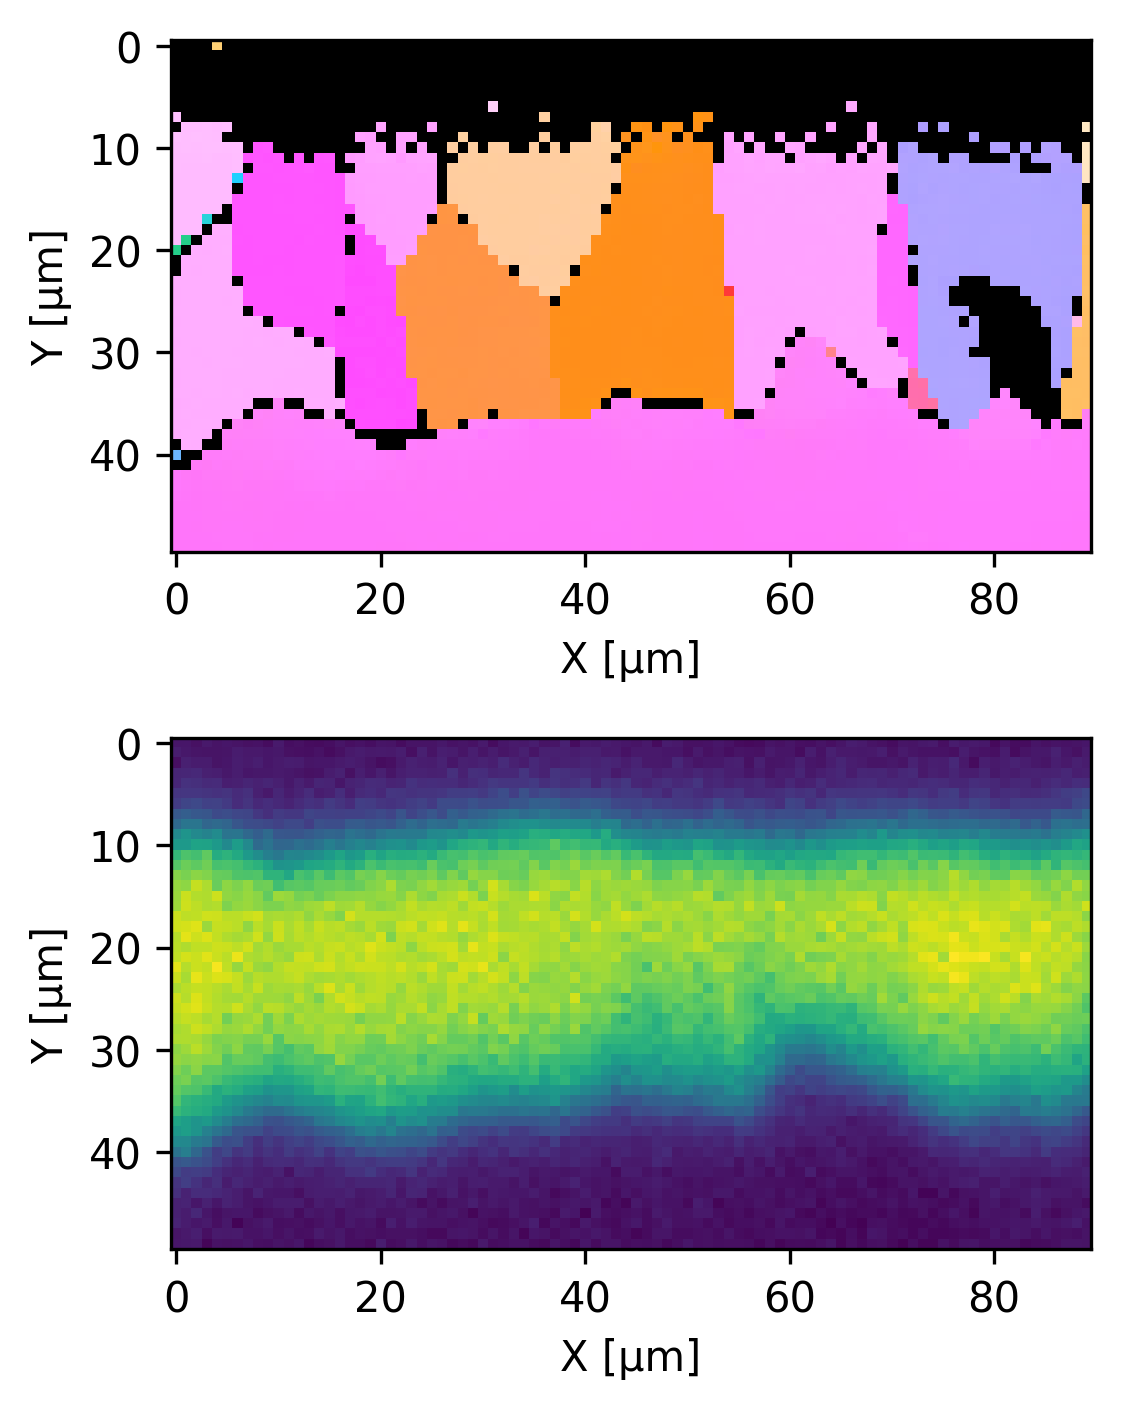

In [281]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation
import matplotlib.colors as colors

fig, axs = plt.subplots(2,1,dpi=300)
f = h5py.File(data_folder+sorted_files[10], 'r')

axs[0].set_xlabel("X [μm]")
axs[1].set_xlabel("X [μm]")
axs[0].set_ylabel("Y [μm]")
axs[1].set_ylabel("Y [μm]")

axs[0].invert_yaxis()
axs[1].invert_yaxis()

image_resolution = (f['1/EDS/Header/X Cells'][0],f['1/EDS/Header/Y Cells'][0])
crop = slice(35, 85),slice(15, 105)

EBSD_data = np.array(f['1/EBSD/Data/Euler']).reshape(image_resolution[1],image_resolution[0],3)

EBSD_data = np.flip(EBSD_data,axis=0)

EBSD_data = EBSD_data[crop]


map1 = axs[0].imshow(EBSD_data)
#c = fig.colorbar(map1, ax=axs)

#axs[0].set_xlim(0,f['1/EBSD/Header/Bounding Box Size'][0])
#axs[0].set_ylim(0,f['1/EBSD/Header/Bounding Box Size'][1])



Sn_data = np.array(f['1/EDS/Data/Window Integral/Sn Lα1']).reshape(image_resolution[1],image_resolution[0])

Sn_data = np.flip(Sn_data,axis=0)

Sn_data = Sn_data[crop]


Nb_data = np.array(f['1/EDS/Data/Window Integral/Nb Lα1']).reshape(image_resolution[1],image_resolution[0])

Nb_data = np.flip(Nb_data,axis=0)

Nb_data = Nb_data[crop]


map2 = axs[1].imshow(Sn_data)

fig.tight_layout()



In [282]:
ind = np.indices(EBSD_data.shape[:2])

coord_grid = np.stack((ind[0]*0.1,ind[1]*0.1),axis=-1)

In [283]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation


euler_points = EBSD_data.reshape(EBSD_data.shape[0]*EBSD_data.shape[1],EBSD_data.shape[-1])

EDS_points = EDS_data.reshape(EDS_data.shape[0]*EDS_data.shape[1],1)


coordinates = coord_grid.reshape(coord_grid.shape[0]*coord_grid.shape[1],coord_grid.shape[-1])

EDS_coordinates = coordinates

non_zero = list(not(np.array_equal(euler_points[i,:],np.array((0.0,0.0,0.0)))) for i in range(euler_points.shape[0]))
coordinates = coordinates[non_zero]
euler_points = euler_points[non_zero]

# subsample = np.random.randint(0,coordinates.shape[0],size=10000)

# euler_points = euler_points[subsample]
# coordinates = coordinates[subsample]

rotations = Rotation.from_euler('XZX',euler_points)



In [284]:
from scipy._lib.decorator import decorator as _decorator

def _adjust_bounds(ax, points):
    margin = 0.1 * np.ptp(points, axis=0)
    xy_min = points.min(axis=0) - margin
    xy_max = points.max(axis=0) + margin
    ax.set_xlim(xy_min[0], xy_max[0])
    ax.set_ylim(xy_min[1], xy_max[1])

@_decorator
def _held_figure(func, obj, ax=None, **kw):
    import matplotlib.pyplot as plt

    if ax is None:
        fig = plt.figure()
        ax = fig.gca()
        return func(obj, ax=ax, **kw)

    # As of matplotlib 2.0, the "hold" mechanism is deprecated.
    # When matplotlib 1.x is no longer supported, this check can be removed.
    was_held = getattr(ax, 'ishold', lambda: True)()
    if was_held:
        return func(obj, ax=ax, **kw)
    try:
        ax.hold(True)
        return func(obj, ax=ax, **kw)
    finally:
        ax.hold(was_held)


import itertools

@_held_figure
def voronoi_plot_2d(vor, ax=None, **kw):
    """
    Plot the given Voronoi diagram in 2-D

    Parameters
    ----------
    vor : scipy.spatial.Voronoi instance
        Diagram to plot
    ax : matplotlib.axes.Axes instance, optional
        Axes to plot on
    show_points : bool, optional
        Add the Voronoi points to the plot.
    show_vertices : bool, optional
        Add the Voronoi vertices to the plot.
    line_colors : string, optional
        Specifies the line color for polygon boundaries
    line_width : float, optional
        Specifies the line width for polygon boundaries
    line_alpha : float, optional
        Specifies the line alpha for polygon boundaries
    point_size : float, optional
        Specifies the size of points

    Returns
    -------
    fig : matplotlib.figure.Figure instance
        Figure for the plot

    See Also
    --------
    Voronoi

    Notes
    -----
    Requires Matplotlib.

    Examples
    --------
    >>> import numpy as np
    >>> import matplotlib.pyplot as plt
    >>> from scipy.spatial import Voronoi, voronoi_plot_2d

    Create a set of points for the example:

    >>> rng = np.random.default_rng()
    >>> points = rng.random((10,2))

    Generate the Voronoi diagram for the points:

    >>> vor = Voronoi(points)

    Use `voronoi_plot_2d` to plot the diagram:

    >>> fig = voronoi_plot_2d(vor)

    Use `voronoi_plot_2d` to plot the diagram again, with some settings
    customized:

    >>> fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='orange',
    ...                       line_width=2, line_alpha=0.6, point_size=2)
    >>> plt.show()

    """
    from matplotlib.collections import LineCollection

    if vor.points.shape[1] != 2:
        raise ValueError("Voronoi diagram is not 2-D")

    if kw.get('show_points', True):
        point_size = kw.get('point_size', None)
        ax.plot(vor.points[:, 0], vor.points[:, 1], '.', markersize=point_size)
    if kw.get('show_vertices', True):
        ax.plot(vor.vertices[:, 0], vor.vertices[:, 1], 'o')

    line_colors = kw.get('line_colors', 'k')
    line_width = kw.get('line_width', 1.0)
    line_alpha = kw.get('line_alpha', 1.0)

    center = vor.points.mean(axis=0)
    ptp_bound = np.ptp(vor.points, axis=0)

    finite_segments = []
    infinite_segments = []
    GBs = []
    for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):

        misorientation = rotations[pointidx[0]] * rotations[pointidx[1]].inv()
        misorientation = np.linalg.norm(misorientation.as_rotvec())


        simplex = np.asarray(simplex)
        if np.all(simplex >= 0):
            finite_segments.append(vor.vertices[simplex])
            
            if misorientation > 0.1:
                GBs.append(vor.vertices[simplex])
        else:
            i = simplex[simplex >= 0][0]  # finite end Voronoi vertex

            t = vor.points[pointidx[1]] - vor.points[pointidx[0]]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[pointidx].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            if (vor.furthest_site):
                direction = -direction
            aspect_factor = abs(ptp_bound.max() / ptp_bound.min())
            far_point = vor.vertices[i] + direction * ptp_bound.max() * aspect_factor

            infinite_segments.append([vor.vertices[i], far_point])

    for i, regionid in enumerate(vor.point_region):

        # print(f"point index: {i}")
        # print(f"region ID: {regionid}")
        
        if -1 not in vor.regions[regionid]:

            color = euler_points[i,:]/np.array((2*np.pi,np.pi/2,np.pi/2))
            vertices = vor.vertices[vor.regions[regionid]]
            vertices = np.asarray(vertices)
            ax.fill(vertices[:,0],vertices[:,1],facecolor=color)

    ax.add_collection(LineCollection(finite_segments,
                                     colors=line_colors,
                                     lw=line_width,
                                     alpha=line_alpha,
                                     linestyle='solid'))
    ax.add_collection(LineCollection(infinite_segments,
                                     colors=line_colors,
                                     lw=line_width,
                                     alpha=line_alpha,
                                     linestyle='dashed'))
    ax.add_collection(LineCollection(GBs,
                                     colors='r',
                                     lw=line_width,
                                     alpha=line_alpha,
                                     linestyle='solid'))

    _adjust_bounds(ax, vor.points)

    return ax.figure


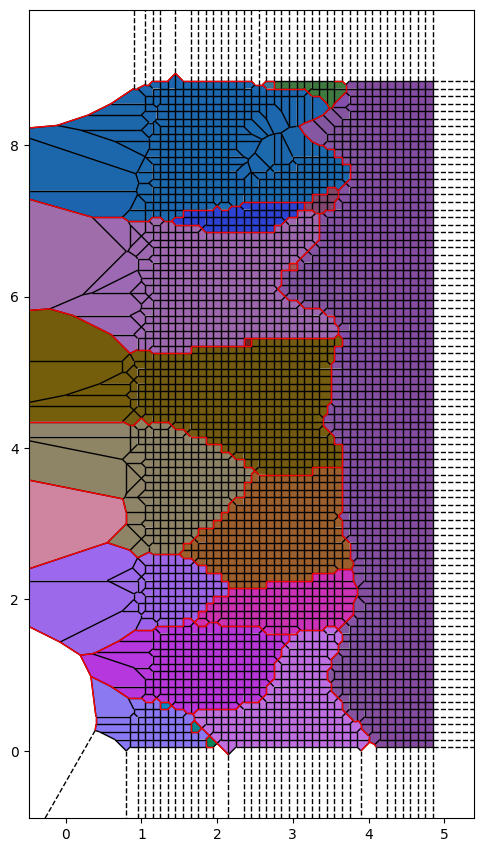

In [285]:
from scipy.spatial import Voronoi

vor = Voronoi(coordinates)
import matplotlib.pyplot as plt
fig = voronoi_plot_2d(vor,show_vertices=False,show_points=False)
# fig.axes[0].scatter(vor.points[:, 0], vor.points[:, 1],
#                     c=euler_points/np.array((2*np.pi,np.pi,np.pi))[None,:],
#                     s=5)
fig.axes[0].set_aspect('equal')
fig.set_size_inches(18.5, 10.5)
plt.show()

In [286]:
misorientations = rotations[vor.ridge_points[:,0]] * rotations[vor.ridge_points[:,1]].inv()
misorientations = np.linalg.norm(misorientations.as_rotvec(),axis=-1)

# GBs = [i for (i,v) in zip(vor.ridge_points,(misorientations > 0.1)) if v]
# nonGBs = [i for (i,v) in zip(vor.ridge_points,(misorientations < 0.1)) if v]

# GBs = vor.point_region[vor.ridge_points[misorientations > 0.1]]
# nonGBs = vor.point_region[vor.ridge_points[misorientations < 0.1]]

GBs = np.arange(0,vor.ridge_points.shape[0])[misorientations > 0.1]
nonGBs = np.arange(0,vor.ridge_points.shape[0])[misorientations <= 0.1]



In [287]:
from scipy.sparse import csr_array
from scipy.sparse.csgraph import breadth_first_tree

csr_grains = csr_array((np.ones((nonGBs.shape[0])),
                        (vor.point_region[vor.ridge_points[nonGBs]][:,0],
                         vor.point_region[vor.ridge_points[nonGBs]][:,1])),
                             shape=(len(vor.regions),len(vor.regions)))

csr_grain = breadth_first_tree(csr_grains,2000,directed=False)

csr_grain = csr_grain.tocoo()

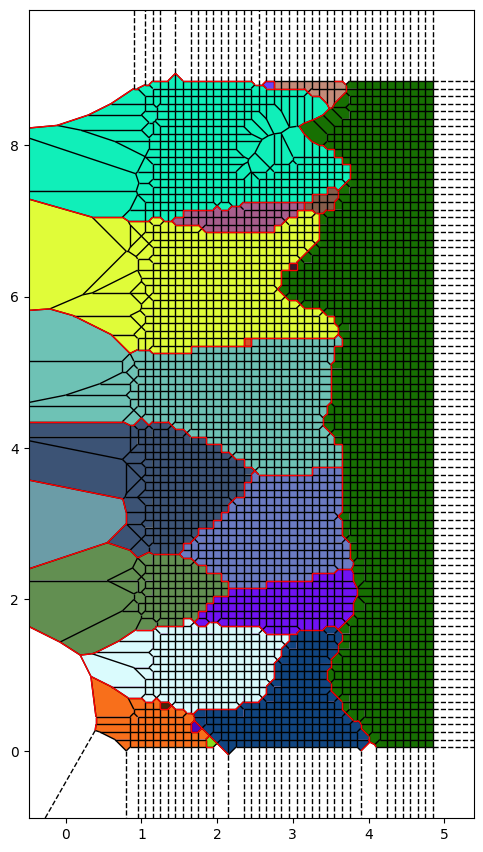

In [288]:
remaining_regions = vor.point_region
grains = []

while remaining_regions.shape[0] > 0:
    csr_grain = breadth_first_tree(csr_grains,remaining_regions[0],directed=False)

    csr_grain = csr_grain.tocoo()

    grain_regions = np.unique(np.concatenate((csr_grain.coords[0],csr_grain.coords[1],remaining_regions[0,None])))

    remaining_regions = np.setdiff1d(remaining_regions,grain_regions,assume_unique=True)

    grains.append(grain_regions)

    grain_ids = [vor.regions[v] for v in grain_regions]
    color = np.random.rand(3,)

    ax = fig.axes[0]

    for i, regionid in enumerate(grain_ids):

        # print(f"point index: {i}")
        # print(f"region ID: {regionid}")
        
        if -1 not in regionid:

            vertices = vor.vertices[regionid]
            vertices = np.asarray(vertices)
            ax.fill(vertices[:,0],vertices[:,1],facecolor=color)

fig

In [289]:
# vor_region_ridges = [np.arange(0,vor.ridge_points.shape[0])[(vor.ridge_points == i).any(axis=-1)].tolist() for i in range(vor.ridge_points.shape[0])]

In [290]:
# from matplotlib.collections import LineCollection
# grain = grains[0]
# grainGBs = vor.vertices[[vor.ridge_vertices[i] for i in [vor_region_ridges[i][j] for i in grain for j in range(len(vor_region_ridges[i]))]]]


# ax.add_collection(LineCollection(grainGBs,
#                                 colors='b',
#                                 lw=1,
#                                 alpha=1,
#                                 linestyle='solid'))

# fig

In [291]:
# T_VE = csr_array((len(vor.vertices),len(vor.ridge_vertices)))
# T_EF = csr_array((len(vor.ridge_vertices),len(vor.ridge_points)))

In [292]:
T_VF = csr_array((len(vor.vertices),len(vor.ridge_points)))
for face, vertices in enumerate(vor.ridge_vertices):
    T_VF[vertices,face] = 1

c:\Users\viklund\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [293]:
vor_region_ridges = [np.arange(0,vor.ridge_points.shape[0])[(vor.ridge_points == i).any(axis=-1)].tolist() for i in range(vor.ridge_points.shape[0])]

In [294]:
T_FD = csr_array((len(vor.ridge_points),len(vor.regions)))
for face in np.arange(0,vor.ridge_points.shape[0]):
    for domain in vor.point_region[vor.ridge_points[face,:]]:
        T_FD[face,domain] = 1

c:\Users\viklund\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [295]:
misorientations = rotations[vor.ridge_points[:,0]] * rotations[vor.ridge_points[:,1]].inv()
misorientations = np.linalg.norm(misorientations.as_rotvec(),axis=-1)

# GBs = [i for (i,v) in zip(vor.ridge_points,(misorientations > 0.1)) if v]
# nonGBs = [i for (i,v) in zip(vor.ridge_points,(misorientations < 0.1)) if v]

# GBs = vor.point_region[vor.ridge_points[misorientations > 0.1]]
# nonGBs = vor.point_region[vor.ridge_points[misorientations < 0.1]]

GBs = np.arange(0,vor.ridge_points.shape[0])[misorientations > 0.1]
nonGBs = np.arange(0,vor.ridge_points.shape[0])[misorientations <= 0.1]

In [296]:
A_DGB = csr_array((len(vor.regions),len(vor.regions)))
T_FDGB = csr_array(T_FD.shape)

for domain in range(T_FD.shape[1]):
    T_FDGB[:,domain] = T_FD[:,[domain]] * (misorientations > 0.1)[:,None]


c:\Users\viklund\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [297]:
A_DGB = 1*((T_FDGB.T @ T_FDGB) > 0)

In [298]:
A_D = 1*((T_FD.T @ T_FD) > 0)

In [299]:
A_DnonGB = A_D - A_DGB

In [300]:
A_DnonGB.data

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

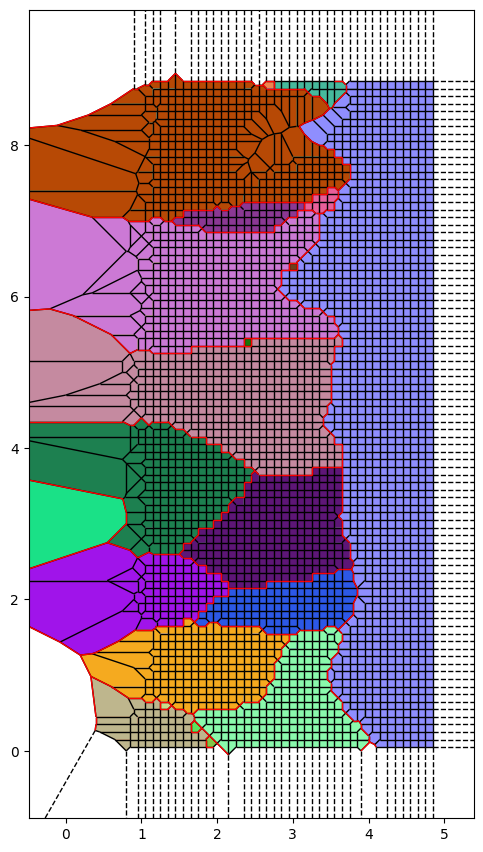

In [301]:
remaining_regions = vor.point_region
grains = []

while remaining_regions.shape[0] > 0:
    csr_grain = breadth_first_tree(A_DnonGB,remaining_regions[0],directed=False)

    csr_grain = csr_grain.tocoo()

    grain_regions = np.unique(np.concatenate((csr_grain.coords[0],csr_grain.coords[1],remaining_regions[0,None])))

    remaining_regions = np.setdiff1d(remaining_regions,grain_regions,assume_unique=True)

    grains.append(grain_regions)

    grain_ids = [vor.regions[v] for v in grain_regions]
    color = np.random.rand(3,)

    ax = fig.axes[0]

    for i, regionid in enumerate(grain_ids):

        # print(f"point index: {i}")
        # print(f"region ID: {regionid}")
        
        if -1 not in regionid:

            vertices = vor.vertices[regionid]
            vertices = np.asarray(vertices)
            ax.fill(vertices[:,0],vertices[:,1],facecolor=color)

fig

In [302]:
T_PD = csr_array((len(vor.point_region),len(vor.regions)))

for point, domain in enumerate(vor.point_region):   
    T_PD[point,domain] = 1

In [303]:
T_DG = csr_array((len(vor.regions),len(grains)))

for i, grain in enumerate(grains):
    for domain in grain:
        T_DG[domain,i] = 1

In [304]:
B_D = T_DG @ T_DG.T

In [305]:
GB_Faces = T_FD@(B_D * A_DGB)@T_DG * (T_FD@T_DG)

In [306]:
GB_vertices = vor.vertices[[vor.ridge_vertices[f] for f in range(GB_Faces.shape[0]) if GB_Faces[f,12] == 1]]

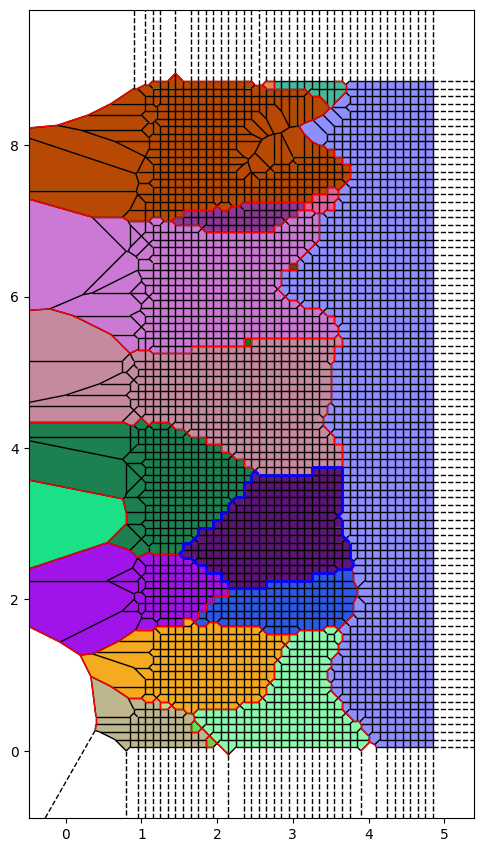

In [307]:
from matplotlib.collections import LineCollection

ax.add_collection(LineCollection(GB_vertices,
                                colors='b',
                                lw=2,
                                alpha=1,
                                linestyle='solid'))

fig

In [308]:
def linesegment_distance(P_0,P_1,P_2):
    A = np.abs(np.cross((P_0 - P_1),(P_2 - P_1)))
    d = np.linalg.norm(P_2 - P_1,ord=2,axis=-1)
    p = np.einsum('...k,...k->...',(P_0 - P_1),(P_2 - P_1))/d**2
    

    a = A/d
    b = np.linalg.norm(P_0 - P_1,ord=2,axis=-1)
    c = np.linalg.norm(P_0 - P_2,ord=2,axis=-1)

    return (a*np.bitwise_and((p>=0),(p<=1)) + b*(p<0) + c*(p>1)).min(axis=1)



In [309]:
X,Y = np.meshgrid(np.linspace(0,5,num=100),np.linspace(0,9,num=100))
points = np.array((X.flatten(),Y.flatten())).T

distances = linesegment_distance(EDS_coordinates[:,None,:],GB_vertices[None,:,0,:],GB_vertices[None,:,1,:])


In [310]:
T_PG =  T_PD @ T_DG

In [311]:
def segment_intersection(x0,x1,p0,p1):
    s0 = x1-x0
    s1 = p1-p0
    v = p0-x0

    cross = np.cross(s0,s1)

    u = np.cross(v,s0)/cross
    t = np.cross(v,s1)/cross

    intersection = p0 + np.stack([t,t],axis=-1)*s1

    return intersection * (np.greater_equal(u,0) * np.greater_equal(t,0) * np.less_equal(u,1) * np.less_equal(t,1))[...,None]


In [312]:
inside_points = vor.points[(T_PG[:,[5]] == 1).toarray()[:,0],:]
inside_point = inside_points[10]

intersections = np.sum(np.prod(np.greater(segment_intersection(inside_point[None,None,:],points[:,None,:],GB_vertices[None,:,0,:],GB_vertices[None,:,1,:]),0),axis=-1),axis=-1)

C:\Users\viklund\AppData\Local\Temp\ipykernel_20556\3705485142.py:8: RuntimeWarning: divide by zero encountered in divide
  u = np.cross(v,s0)/cross
C:\Users\viklund\AppData\Local\Temp\ipykernel_20556\3705485142.py:9: RuntimeWarning: divide by zero encountered in divide
  t = np.cross(v,s1)/cross
C:\Users\viklund\AppData\Local\Temp\ipykernel_20556\3705485142.py:13: RuntimeWarning: invalid value encountered in multiply
  return intersection * (np.greater_equal(u,0) * np.greater_equal(t,0) * np.less_equal(u,1) * np.less_equal(t,1))[...,None]


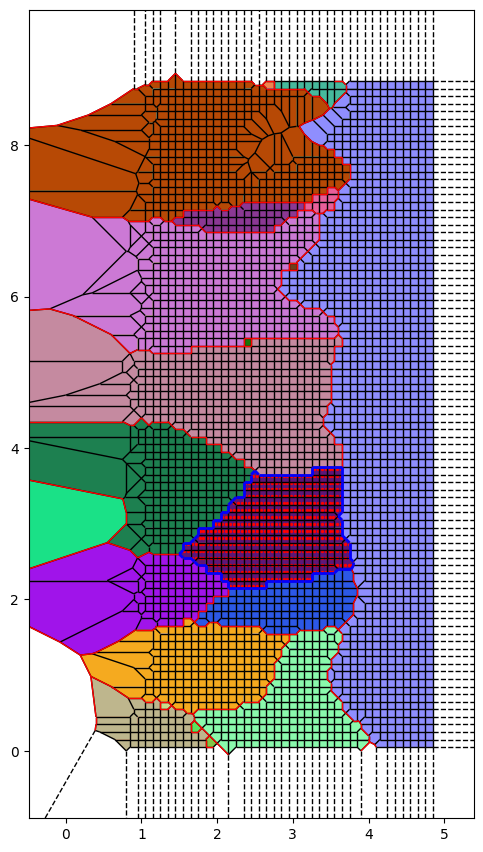

In [313]:
in_points = points[np.not_equal(np.mod(intersections,2),0)]
ax.scatter(in_points[:,0],in_points[:,1],c='r',s=2)
fig

In [314]:
from skimage import measure

EDS_data = Sn_data + Nb_data

contours = measure.find_contours(EDS_data,100000)

In [315]:
EDS_data.max()

204325.14

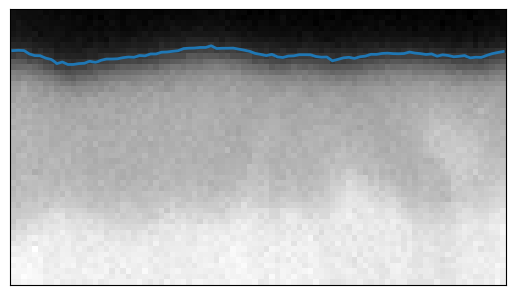

In [316]:
# Display the image and plot all contours found
fig2, ax2 = plt.subplots()
ax2.imshow(EDS_data, cmap=plt.cm.gray)

for contour in contours:
    ax2.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax2.axis('image')
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()

In [317]:
border = []

for contour in contours:
    
    border.append(np.array([contour[:-1],contour[1:]]).transpose((1,0,2))*0.1)


border = np.concatenate(border,axis=0)

(3560, 2)